<a href="https://colab.research.google.com/github/jiruneko/26-machine-learning-algorithms/blob/main/BERT_first_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
from torchvision.datasets import MNIST
from torchvision import transforms
from torch.utils.data import DataLoader

# 訓練データを取得
mnist_train = MNIST("./data",
                    train=True, download=True,
                    transform=transforms.ToTensor())
# テストデータの取得
mnist_test = MNIST("./data",
                   train=False, download=True,
                   transform=transforms.ToTensor())
print("訓練データの数：",len(mnist_train), "テストデータの数：",len(mnist_test))

# DataLoaderの設定
img_size = 28
batch_size = 256
train_loader = DataLoader(mnist_train,
                          batch_size=batch_size,
                          shuffle=True)
test_loader = DataLoader(mnist_test,
                         batch_size=batch_size,
                         shuffle=False)

100%|██████████| 9912422/9912422 [00:00<00:00, 180906327.35it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 39560971.20it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 46062950.56it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 16979080.90it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

訓練データの数： 60000 テストデータの数： 10000


In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
  def __init__(self):
    super().__init__()
    self.fc1 = nn.Linear(img_size*img_size, 1024) #全結合層
    self.fc2 = nn.Linear(1024, 512)
    self.fc3 = nn.Linear(512, 10)

  def forward(self, x):
    x = x.view(-1, img_size*img_size) #バッチサイズ×入力の数
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)
    return x

net = Net()
net.cuda()
print(net)

Net(
  (fc1): Linear(in_features=784, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=10, bias=True)
)


In [ ]:
from torch import optim

# 交差エントロピー誤差関数
loss_fnc = nn.CrossEntropyLoss()

# SGD
optimizer = optim.SGD(net.parameters(), lr=0.01)

# 損失のログ
record_loss_train = []
record_loss_test = []

# 学習
for i in range(10): #10エポック学習
  net.train() #訓練モード
  loss_train = 0
  for j, (x, t) in enumerate(train_loader):
    x, t = x.cuda(), t.cuda() #GPU対応
    y = net(x)
    loss = loss_fnc(y, t)
    loss_train += loss.item()
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
  loss_train /= j + 1
  record_loss_train.append(loss_train)

  net.eval() #評価モード
  loss_test = 0
  for j, (x, t) in enumerate(test_loader):
    x, t = x.cuda(), t.cuda()
    y = net(x)
    loss = loss_fnc(y, t)
    loss_test += loss.item()
  loss_test /= j+1
  record_loss_test.append(loss_test)

  if i % 1 == 0:
    print("Epoch:", i, "Loss_Train:", loss_train, "Loss_Test:", loss_test)

Epoch: 0 Loss_Train: 2.22444624494999 Loss_Test: 2.105315309762955
Epoch: 1 Loss_Train: 1.852710824824394 Loss_Test: 1.4764875501394272
Epoch: 2 Loss_Train: 1.1326599760258451 Loss_Test: 0.8297616079449653
Epoch: 3 Loss_Train: 0.7183503564367903 Loss_Test: 0.5942352212965488
Epoch: 4 Loss_Train: 0.5591715873555935 Loss_Test: 0.4896219130605459
Epoch: 5 Loss_Train: 0.4799955816979104 Loss_Test: 0.4312097545713186
Epoch: 6 Loss_Train: 0.4328078604759054 Loss_Test: 0.39500968214124443
Epoch: 7 Loss_Train: 0.4012549399061406 Loss_Test: 0.36961426567286254
Epoch: 8 Loss_Train: 0.3783811159590457 Loss_Test: 0.35014848243445157
Epoch: 9 Loss_Train: 0.3607268215493953 Loss_Test: 0.33468578876927496


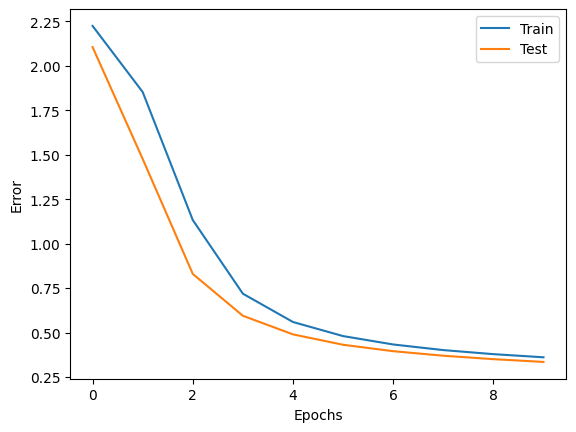

In [ ]:
import matplotlib.pyplot as plt

plt.plot(range(len(record_loss_train)), record_loss_train, label="Train")
plt.plot(range(len(record_loss_test)), record_loss_test, label="Test")
plt.legend()

plt.xlabel("Epochs")
plt.ylabel("Error")
plt.show()

In [ ]:
correct = 0
total = 0
for i, (x, t) in enumerate(test_loader):
  x, t = x.cuda(), t.cuda() #GPU対応
  x = x.view(-1, img_size*img_size)
  y = net(x)
  correct += (y.argmax(1) == t).sum().item()
  total += len(x)
print("正解率:", str(correct/total*100) + "%")

正解率: 90.47%
